# RAIN PREDICTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

In [2]:
data = pd.read_csv("./input/weatherAUS/weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not.**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Points to notice:

- There are missing values in the dataset
- Dataset includes numeric and categorical values

## DATA VISUALIZATION AND CLEANING

Steps involves in this section:

- Count plot of target column
- Correlation amongst numeric attributes
- Parse Dates into datetime
- Encoding days and months as continuous cyclic features

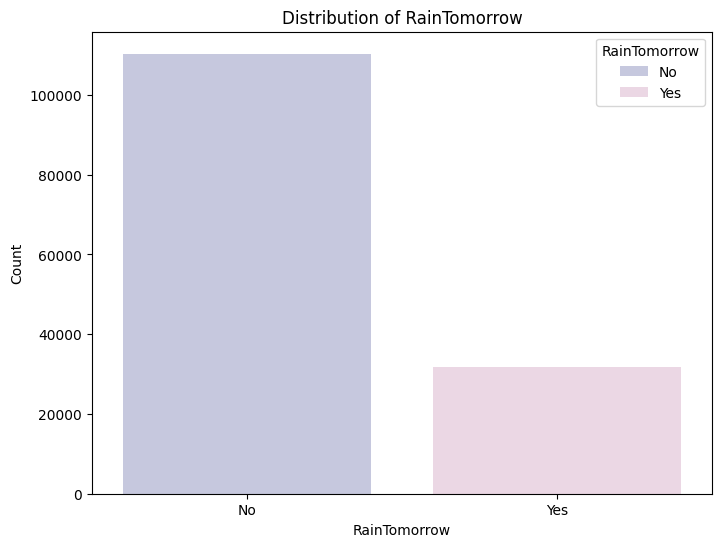

In [4]:
# Count plot of the target column to check for class imbalance
cols = ["#C2C4E2", "#EED4E5"]
plt.figure(figsize=(8, 6))
sns.countplot(x="RainTomorrow", hue="RainTomorrow", data=data, palette=cols, legend=True)
plt.title('Distribution of RainTomorrow')
plt.xlabel('RainTomorrow')
plt.ylabel('Count')
plt.show()

<Axes: >

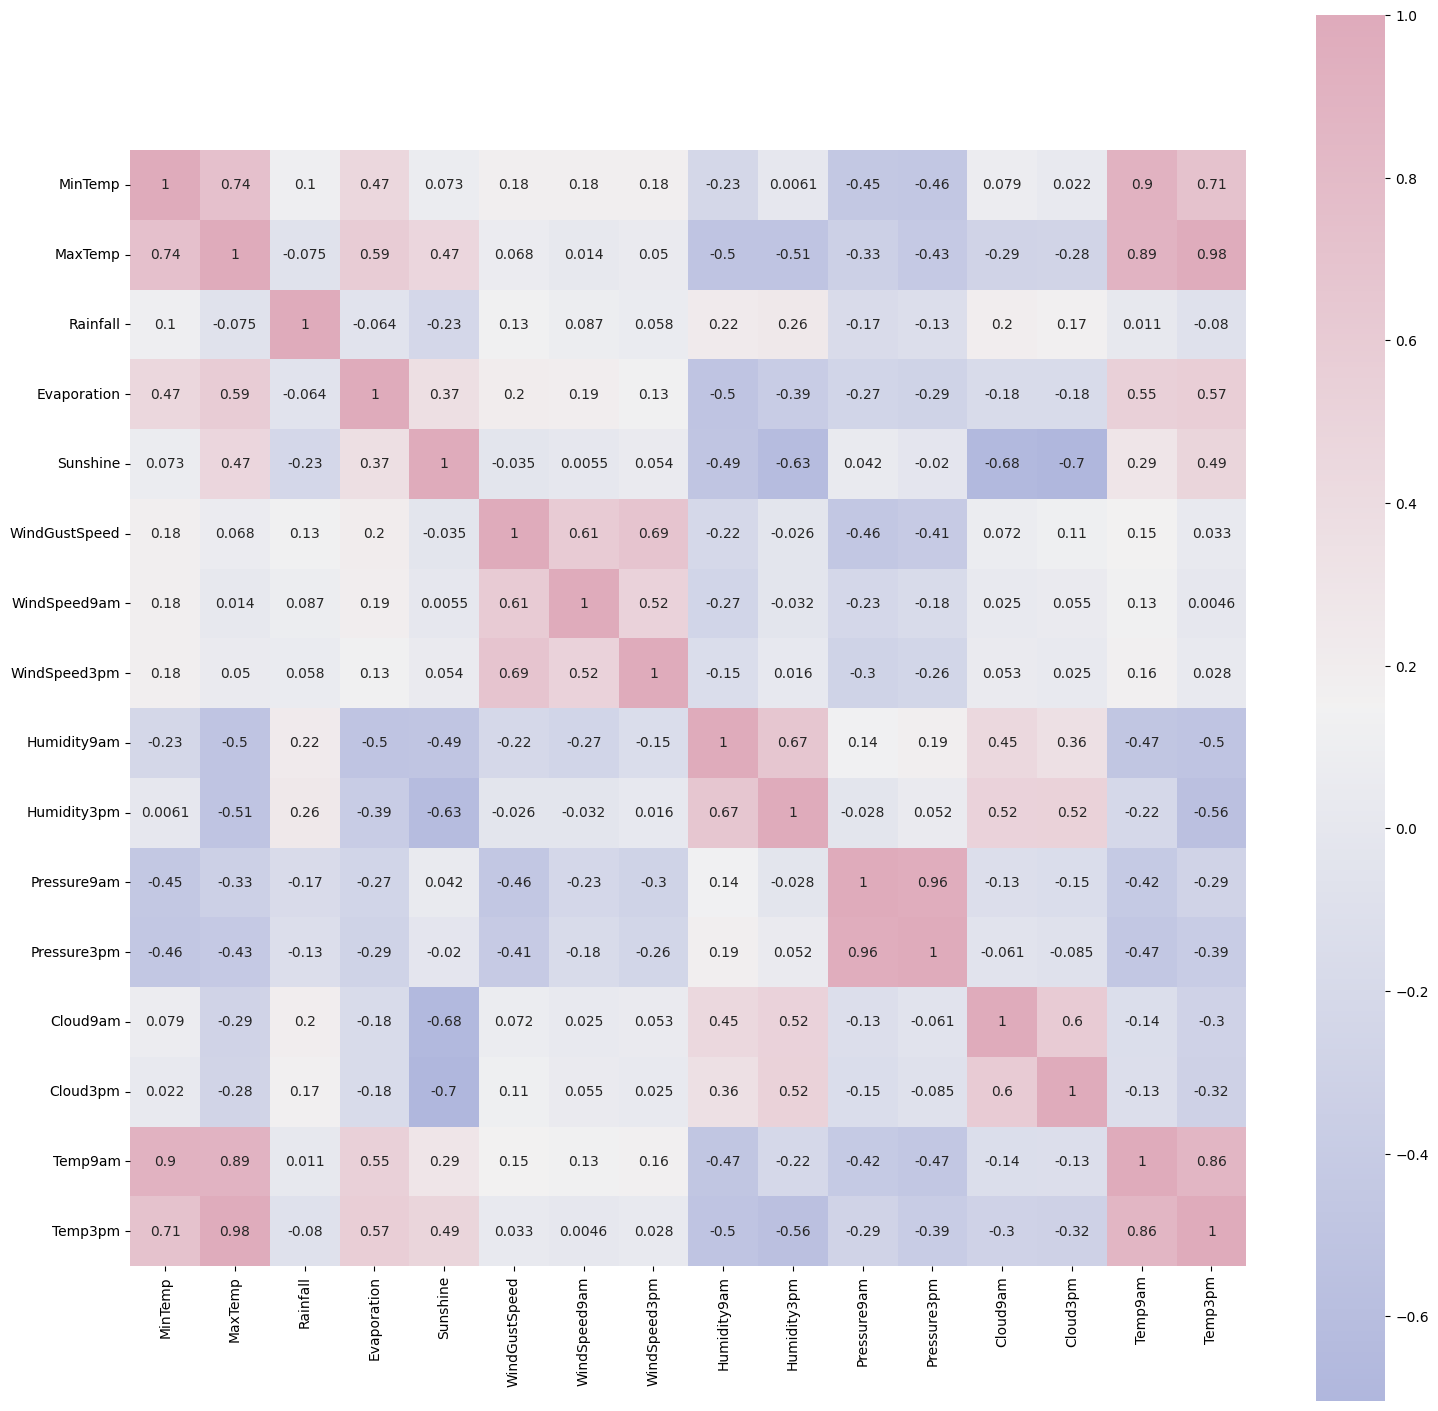

In [5]:
# Correlation amongst numeric attributes
selected_data = data.select_dtypes(include=['int64', 'float64'])
corrmat = selected_data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

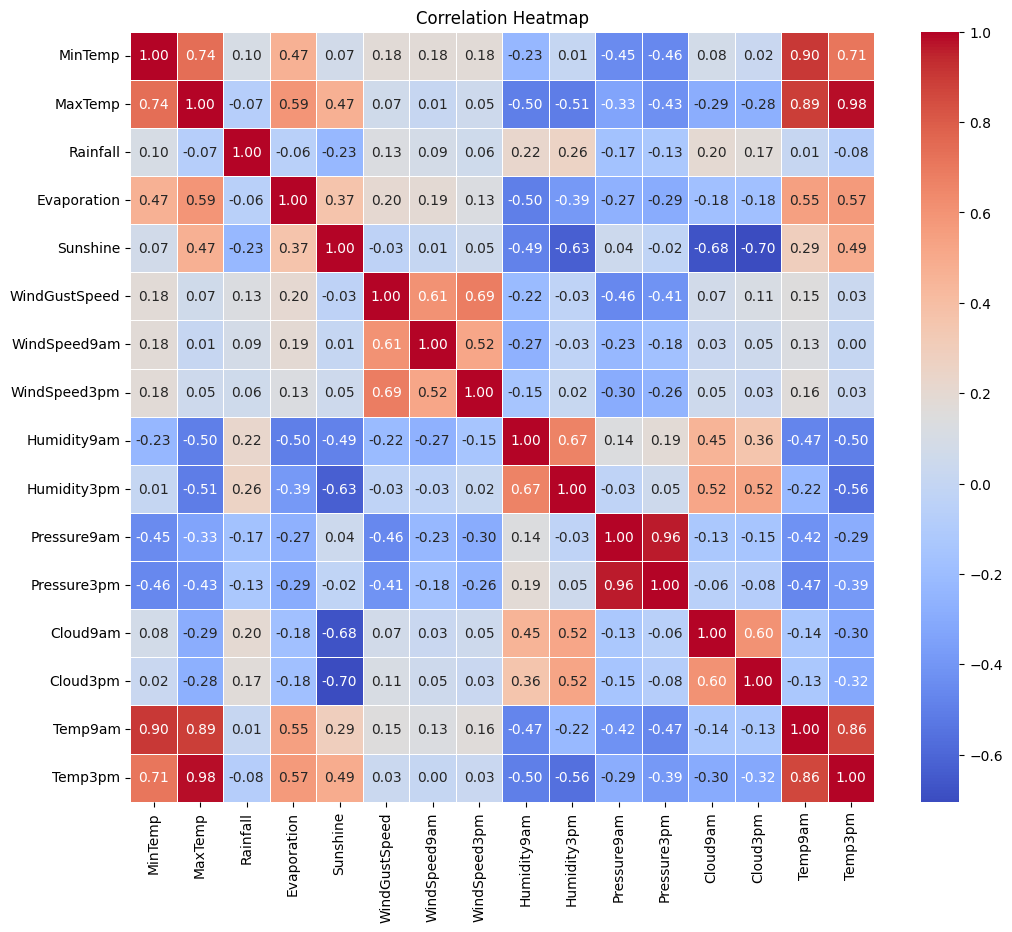

In [6]:
# Correlation among numeric attributes
numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()



In [7]:
#Parsing datetime
#exploring the length of date objects
data.info()
print(data.columns)
lengths = data["Date"].str.len()
# print(lengths)
lengths.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Date
10    145460
Name: count, dtype: int64

***
Creating additional features for year, month, and day using cyclic encoding is particularly beneficial when dealing with periodic or cyclical data in machine learning models, especially neural networks. Here's why we do this:

* Cyclical Nature of Time: Time-related features such as year, month, and day exhibit a cyclical nature. For example, months cycle from January to December, and days cycle from 1 to 31. Neural networks may struggle to understand the cyclical patterns in these features if they are treated as linear or ordinal variables.

* Avoiding Discontinuity: By encoding these cyclical features using sine and cosine functions, we transform them into continuous variables that represent their cyclical nature more accurately. This helps the neural network learn from the data more effectively and reduces the risk of introducing discontinuities at the boundaries of cyclical features.

* Improved Generalization: Cyclic encoding allows neural networks to generalize better across different periods within a cycle. For example, the neural network can learn that December and January are close in a cyclical sense, rather than treating them as distant months.

* Reducing Model Complexity: Cyclic encoding simplifies the representation of time-related features for the neural network. Instead of treating each month or day as a separate category, the neural network can learn smooth transitions between different time points, leading to a more parsimonious model representation.
***

In [8]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

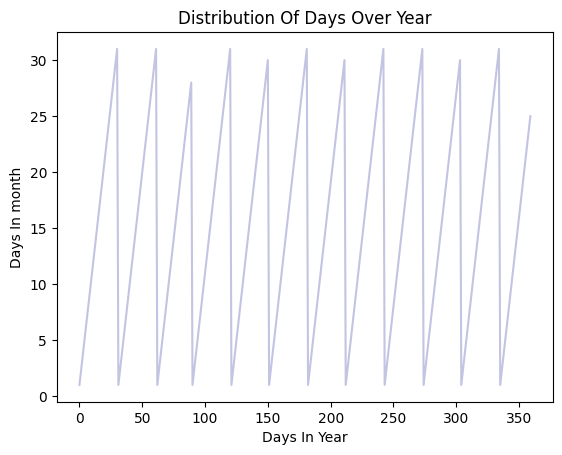

In [9]:
# roughly a year's span section 
section = data[:360] 
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

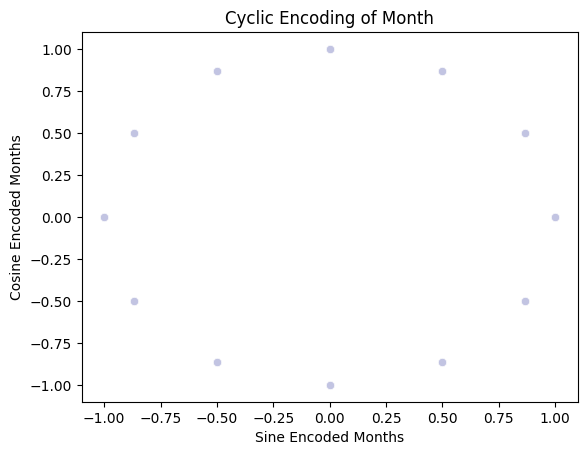

In [10]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

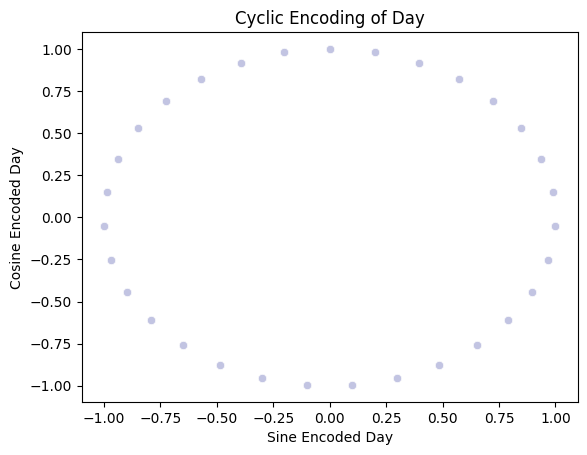

In [11]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Categorical variables are a type of qualitative data that represent categories or groups. Unlike numerical variables, which represent quantities and can be ordered or measured, categorical variables represent qualities or characteristics that fall into specific predefined categories. Here are some key characteristics of categorical variables:

1. **Discrete Categories**: Categorical variables have a limited number of distinct categories or levels. Each observation in the dataset is assigned to one of these categories.

2. **No Inherent Order**: Unlike ordinal variables, where categories have a meaningful order, the categories of a categorical variable have no inherent order. For example, the categories "red," "blue," and "green" in a variable representing colors have no natural order.

3. **Nominal vs. Ordinal**: Categorical variables can be further classified into nominal and ordinal variables:
   - **Nominal variables**: Nominal variables have categories with no inherent order or ranking. Examples include gender (male, female), city (New York, London, Paris), or eye color (brown, blue, green).
   - **Ordinal variables**: Ordinal variables have categories with a meaningful order or ranking. Examples include education level (high school, college, graduate), income level (low, medium, high), or satisfaction level (poor, fair, good, excellent).

4. **Textual or Coded Values**: Categorical variables can be represented using text labels or numerical codes. Textual values provide descriptive labels for each category, while numerical codes represent each category using numeric values.

5. **Encoding for Analysis**: Before using categorical variables in analytical models or machine learning algorithms, they often need to be encoded into a numerical format. This can involve techniques such as one-hot encoding for nominal variables or ordinal encoding for ordinal variables.

Categorical variables play a crucial role in data analysis, visualization, and modeling, especially when dealing with qualitative or non-numeric data. Understanding the nature of categorical variables is essential for appropriate data preprocessing, analysis, and interpretation.

In [12]:
# Get list of categorical variables
s = (data.dtypes == "object")
# print(s)
object_cols = list(s[s].index)

print(f"Categorical variables:-")
print(object_cols)

Categorical variables:-
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [13]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [14]:
#Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

Numerical variables

- Filling missing values with median of the column value

In [15]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [16]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [17]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

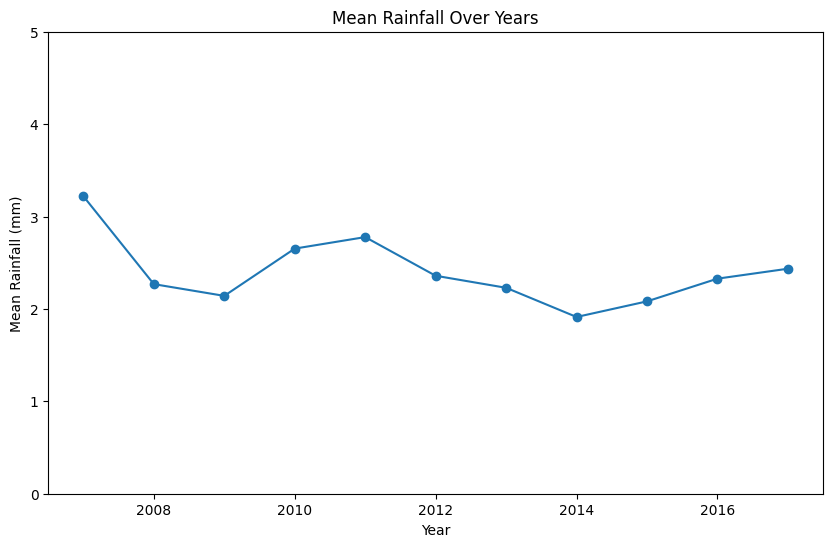

In [18]:
# Group data by year and calculate mean rainfall for each year
yearly_rainfall = data.groupby(data['Date'].dt.year)['Rainfall'].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(yearly_rainfall.index, yearly_rainfall.values, marker='o', linestyle='-')
plt.title('Mean Rainfall Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Rainfall (mm)')
plt.grid(False)
plt.ylim(0, 5)   # Limit y-axis to maximum value of 5
plt.show()

In [21]:
# Define base colors
base_colors = ["pink"]

# Calculate the number of unique years
num_unique_years = len(data['Date'].unique())

# Create a custom palette with light shades of the base colors
palette = []
for color in base_colors:
    palette += sns.light_palette(color, n_colors=num_unique_years, reverse=True)

# Convert yearly_windgust Series to DataFrame
yearly_windgust_df = data.to_frame().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Date', y='WindGustSpeed', data=yearly_windgust_df, hue='Date', palette=palette, dodge=False, legend=False)
plt.title('Mean Wind Gust Speed Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Wind Gust Speed (km/h)')
plt.xticks(rotation=45)
plt.grid(axis='y')  # Add grid lines only on the y-axis
plt.show()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

## DATA PREPROCESSING

Encoding categorical data into numerical form is a necessary preprocessing step in machine learning to ensure compatibility with algorithms, enable mathematical operations, improve model performance, and preserve the underlying information contained in the data.

 `data[i] = label_encoder.fit_transform(data[i])`: Within each iteration of the loop, this line applies label encoding to the values in the column `i`. It first fits the label encoder to the unique values in the column using the `fit_transform()` method, which assigns a unique integer to each unique value. The transformed values are then assigned back to the column `i` in the DataFrame `data`.

After the loop, all categorical columns in the DataFrame `data` have been label encoded.

Finally, `data.info()` is called to display the summary information of the DataFrame, which includes the data types of each column. This allows us to confirm that the label encoding has been applied successfully.

By executing this code, categorical variables in the DataFrame `data` are transformed into numerical values using label encoding, making them suitable for use in machine learning algorithms that require numerical input.

In [22]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int32         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int32         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int32         
 10  WindDir3pm     145460 non-null  int32         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [23]:
features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


Outliers are data points that significantly differ from the majority of other observations in a dataset. These data points are typically distinct from the main distribution of the data and may indicate variability, errors, or rare occurrences in the data.

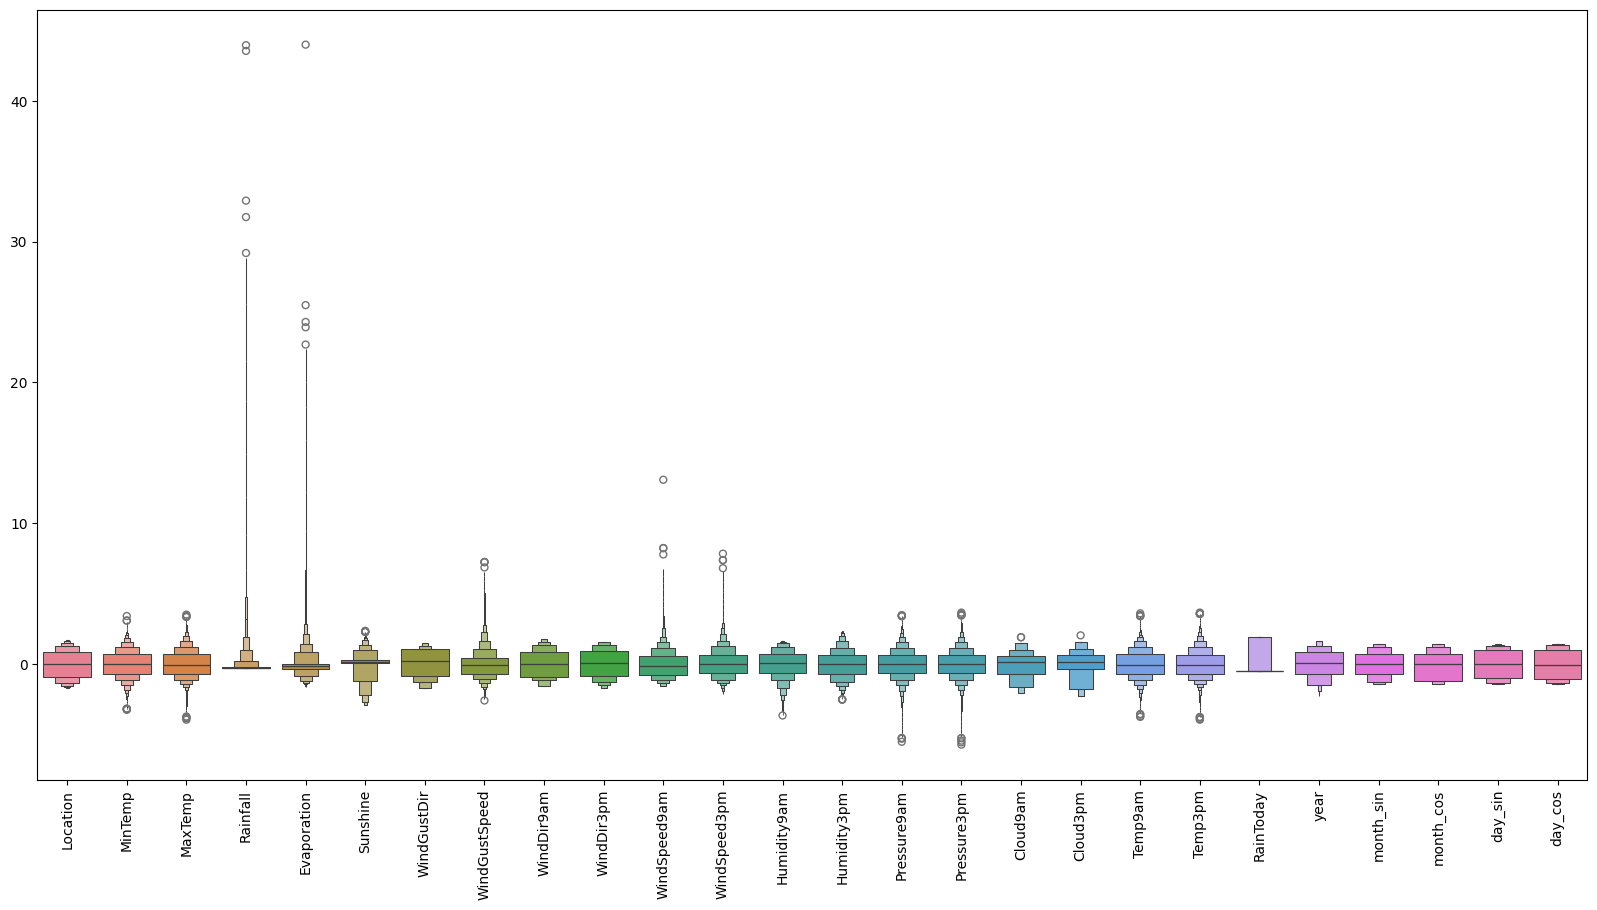

In [24]:
#Detecting outliers
#looking at the scaled features

# Generate a color palette with the required number of unique colors
num_features = len(features.columns)
palette = sns.color_palette("husl", num_features)

# Create the boxen plot using the generated palette
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=palette)
plt.xticks(rotation=90)
plt.show()

- These lines filter the`features` DataFrame to remove outliers based on specific conditions for each feature. For example, it filters out rows where "MinTemp" falls outside the range [-2.3, 2.3], "MaxTemp" falls outside the range [-2, 2.3], and so on for other features.
- Outliers are identified based on thresholds determined empirically or using domain knowledge. The thresholds are chosen to remove extreme values that are considered unrealistic or erroneous.
- Each condition is applied using boolean indexing to select rows where the condition is met.


By executing this code, you'll obtain a filtered `features` DataFrame with outliers removed based on the specified criteria for each feature. This filtering process helps in cleaning the data and improving the quality of the dataset for further analysis or modeling.

In [25]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

In [28]:
features

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos,RainTomorrow
0,-1.531666,0.189757,-0.044575,-0.203581,-0.119472,0.14871,1.045228,0.307739,1.328766,1.366458,...,0.137693,-0.013506,0.019135,-0.529795,-1.879575,-0.016425,1.434192,0.278970,1.426023,0
1,-1.531666,-0.752786,0.265794,-0.275097,-0.119472,0.14871,1.258262,0.307739,-0.221338,1.586813,...,0.137693,0.033011,0.384064,-0.529795,-1.879575,-0.016425,1.434192,0.549587,1.339551,0
2,-1.531666,0.111212,0.350440,-0.275097,-0.119472,0.14871,1.471296,0.460168,1.328766,1.586813,...,-1.286294,0.622225,0.223495,-0.529795,-1.879575,-0.016425,1.434192,0.797572,1.199371,0
3,-1.531666,-0.470023,0.674917,-0.275097,-0.119472,0.14871,-0.872075,-1.216548,0.442992,-1.718521,...,0.137693,0.172562,0.705202,-0.529795,-1.879575,-0.016425,1.434192,1.012774,1.011221,0
4,-1.531666,0.833828,1.281548,-0.155903,-0.119472,0.14871,1.045228,0.079096,-1.328556,-0.176032,...,1.561680,0.126045,1.172312,-0.529795,-1.879575,-0.016425,1.434192,1.186382,0.782805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,1.209285,-1.475402,0.025964,-0.275097,-0.119472,0.14871,-1.724209,-0.683048,0.442992,-1.498165,...,0.137693,-1.067887,0.106718,-0.529795,1.666978,-0.016425,-1.388032,-1.261688,-0.601030,0
145456,1.209285,-1.349730,0.294010,-0.275097,-0.119472,0.14871,-0.446007,-1.368977,0.442992,-1.057454,...,0.137693,-0.943842,0.413259,-0.529795,1.666978,-0.016425,-1.388032,-1.360192,-0.330159,0
145457,1.209285,-1.066967,0.519733,-0.275097,-0.119472,0.14871,-1.085108,-0.225761,0.442992,1.366458,...,0.137693,-0.695753,0.646814,-0.529795,1.666978,-0.016425,-1.388032,-1.403140,-0.044639,0
145458,1.209285,-0.689950,0.533840,-0.275097,-0.119472,0.14871,0.193094,-0.911691,0.664436,-1.057454,...,-1.286294,-0.292607,0.632217,-0.529795,1.666978,-0.016425,-1.388032,-1.388775,0.243842,0


In [27]:
# Save the processed data to a CSV file
features.to_csv('processed_rain_data.csv', index=False)

In [ ]:
#looking at the scaled features without outliers

# Generate a color palette with the required number of unique colors
num_features = len(features.columns)
palette = sns.color_palette("husl", num_features)

# Create the boxen plot using the generated palette
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=palette)
plt.xticks(rotation=90)
plt.show()


## MODEL BUILDING

In this project, we build an artificial neural network.

Following steps are involved in the model building

- Assining X and y the status of attributes and tags
- Splitting test and training sets
- Initialising the neural network
- Defining by adding layers
- Compiling the neural network
- Train the neural network

In [ ]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

This code block sets up an artificial neural network (ANN) using Keras, compiles it, and trains it on the provided data.

1. **Early Stopping Callback**:
    ```python
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001,  # Minimum amount of change to count as an improvement
        patience=20,      # Number of epochs to wait before stopping
        restore_best_weights=True,
    )
    ```
    - This sets up an early stopping callback, which monitors the validation loss during training. If the validation loss doesn't improve by at least `min_delta` for `patience` consecutive epochs, training will be stopped, and the best weights will be restored.

2. **Initializing the Neural Network**:
    ```python
    model = Sequential()
    ```
    - This initializes a sequential model, which is a linear stack of layers.

3. **Adding Layers**:
    - Several dense (fully connected) layers are added to the model using the `add` method of the Sequential model:
        - The first layer (`input_dim=26`) specifies the input shape as 26, corresponding to the number of features.
        - Subsequent layers use the rectified linear unit (ReLU) activation function, except for the last layer, which uses the sigmoid activation function for binary classification.
        - Dropout layers with dropout rates of 0.25 and 0.5 are added to reduce overfitting.
        
4. **Compiling the ANN**:
    ```python
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    ```
    - This compiles the model, specifying the optimizer (Adam with a custom learning rate), loss function (binary crossentropy for binary classification), and metrics to be evaluated during training (accuracy).

5. **Training the ANN**:
    ```python
    history = model.fit(X_train, y_train, batch_size=32, epochs=150, callbacks=[early_stopping], validation_split=0.2)
    ```
    - This trains the model on the training data (`X_train`, `y_train`) for a specified number of epochs (150 in this case) and with a batch size of 32.
    - The `early_stopping` callback is included to monitor the validation loss and stop training early if necessary.
    - The `validation_split=0.2` parameter specifies that 20% of the training data will be used as validation data to monitor the model's performance during training.

This code block sets up, compiles, and trains a neural network model for binary classification using Keras. The training history is stored in the `history` variable for later analysis or visualization.

***
These lines of code are adding layers to a neural network model using the Keras Sequential API. Let's break down each line:

1. **Adding the Input Layer**:
    ```python
    model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_dim=26))
    ```
    - This line adds the input layer to the neural network. It has 32 units (neurons), initialized with a uniform distribution, and uses the ReLU activation function. The `input_dim=26` parameter specifies that the input shape for this layer is 26, corresponding to the number of features in the input data.

2. **Adding Hidden Layers**:
    ```python
    model.add(Dense(units=32, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
    ```
    - These lines add two hidden layers to the neural network. Both layers have 32 and 16 units, respectively, initialized with a uniform distribution, and use the ReLU activation function.

3. **Adding Dropout Layers**:
    ```python
    model.add(Dropout(0.25))
    model.add(Dropout(0.5))
    ```
    - These lines add dropout layers to the neural network. Dropout is a regularization technique used to prevent overfitting by randomly dropping a fraction of units (neurons) during training. The dropout rates are set to 0.25 and 0.5, respectively.

4. **Adding the Output Layer**:
    ```python
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    ```
    - This line adds the output layer to the neural network. It has 1 unit, initialized with a uniform distribution, and uses the sigmoid activation function. For binary classification tasks, the sigmoid activation function is commonly used in the output layer to produce binary predictions (0 or 1).

Overall, these lines define the architecture of a neural network model with multiple layers, including input, hidden, and output layers, using the Sequential API in Keras.
***

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

# Assuming `model` is your trained model
# Save the model to a file
model.save('rain_model.h5')

In [ ]:
# Save the model in the native Keras format
model.save('rain_model.keras')

In [ ]:
history_df = pd.DataFrame(history.history)
# print(history_df)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CONCLUSION

Concluding the model with:

- Testing on the test set
- Evaluating the confusion matrix
- Evaluating the classification report

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

The `classification_report` function generates a text-based summary of key classification metrics for a binary classification model. It provides insights into the precision, recall, F1-score, and support for each class, as well as the overall accuracy and average metrics. Let's break down the output of the `classification_report`:

- **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It measures the accuracy of positive predictions.
- **Recall**: Recall (also known as sensitivity) is the ratio of correctly predicted positive observations to the all observations in actual class. It measures the ability of the model to capture all positive instances.
- **F1-score**: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall, considering both false positives and false negatives.
- **Support**: Support is the number of actual occurrences of the class in the specified dataset.

- For each class (0 and 1 in this example), the report includes precision, recall, and F1-score.
- The `accuracy` row provides the overall accuracy of the model.
- The `macro avg` row calculates the average of precision, recall, and F1-score across classes without considering class imbalance.
- The `weighted avg` row calculates the weighted average of precision, recall, and F1-score, considering class imbalance.

Overall, the classification report provides a comprehensive summary of the performance of a binary classification model, helping to evaluate its effectiveness in classifying instances into different categories.

In [ ]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
print(classification_report(y_test, y_pred, zero_division=1))